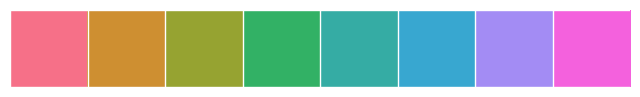

In [3]:
import pandas as pd
import numpy as np
from __future__ import division
import calendar
import time
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from dateutil.parser import parse
from pandas.tslib import Timestamp
colorz=sns.color_palette("husl", 8)
sns.palplot(sns.color_palette("husl", 8))
import matplotlib.dates as mdates

In [5]:
path2='/Users/stella/Desktop/CHTechUSA Data_2017_1002/'

In [43]:
# TEOM & TSI 3783
df1=pd.read_csv(path2+'Data Logger Download.csv')
df1=df1[['Date&Time','PM2.5_FEM_MC','PM10_MC','UF Aggregated Conc.']][1:-8].reset_index()
del df1['index']
df1['Date&Time']=df1['Date&Time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %I:%M %p'))
df1.columns=['time','PM2.5 (ug/m3)','PM10 (ug/m3)','TNC (#/cm3)']
df1['PM2.5 (ug/m3)']=pd.to_numeric(df1['PM2.5 (ug/m3)'], errors='coerce')
df1['PM10 (ug/m3)']=pd.to_numeric(df1['PM10 (ug/m3)'], errors='coerce')
df1['TNC (#/cm3)']=pd.to_numeric(df1['TNC (#/cm3)'], errors='coerce')

#df1=df1.replace(0,np.nan)
num=df1._get_numeric_data()
num[num<=0]=np.nan
#df1[(num[num<=0]).any(1)]                   # CHECK DELETING NEGATIVES
#df1=df1.dropna()

df1_hr=df1.set_index('time').resample(rule='1H').mean().reset_index()
df1_daily=df1.set_index('time').resample(rule='24H').mean().reset_index()

In [343]:
# SMPS TSI 3031
# SMPS TSI 3031
df2=pd.read_csv(path2+'TSI3031_20170701.TXT',delimiter='\t')
df2=df2[['start','end','ch1','ch2','ch3','ch4','ch5','ch6']]
df2['start']=df2['start'].apply(lambda x: parse(x))
df2['end']=df2['end'].apply(lambda x: parse(x))

#num2=df2._get_numeric_data()
num2[num2<=0]=np.nan
#df2[(num[num<=0]).any(1)]                   # CHECK DELETING NEGATIVES
#df2=df2.dropna()
exclude=df2[(df2['start']>=datetime.date(2017,9,12)) & (df2['start']<datetime.date(2017,9,16))].index
exclude=df2.index.isin(exclude)
df2=df2[~exclude]

df2_hr=df2.set_index('start').resample(rule='1H').mean().reset_index()
df2_daily=df2.set_index('start').resample(rule='24H').mean().reset_index()

In [308]:
# TEOM, 3783, 3031 - HOURLY, DAILY
df_hr=df1_hr.set_index('time').join(df2_hr.set_index('start')).reset_index()
df_daily=df1_daily.set_index('time').join(df2_daily.set_index('start')).reset_index()

In [309]:
# PEGASOR INDOOR SN-135 FROM REALECO
ildsa=pd.read_excel(path2+'realeco_sn0135-ldsa_2017-06-30t144100_2017-07-14t144100.xlsx')
ipm=pd.read_excel(path2+'realeco_sn0135-pm25_2017-06-30t145200_2017-07-14t145200.xlsx')
ipn=pd.read_excel(path2+'realeco_sn0135-pn_2017-06-30t145300_2017-07-14t145300.xlsx')
idf=ildsa.set_index('time').join(ipm.set_index('time')).join(ipn.set_index('time')).dropna().reset_index()
idf['time']=idf['time']-datetime.timedelta(hours=1)          # TIME ADJUSTED -1 HOUR

idf=idf[(idf['time']>=datetime.date(2017,7,1)) & (idf['time']<=datetime.date(2017,7,14))].reset_index()
del idf['index']
idf=idf.replace(0,np.nan)

idf_hr=idf.set_index('time').resample(rule='1H').mean().reset_index()
idf_daily=idf.set_index('time').resample(rule='24H').mean().reset_index()

In [310]:
# PEGASOR URBAN FROM AIR MONITORS
urban=pd.read_csv('/Users/stella/Desktop/CHTechUSA Data_2017_1002/Pagesor A_29 June to 02 Oct 2017_UTC0.csv',delimiter=',',encoding='latin-1')
urban=urban[['Alarm','Data','pegasor a','pegasor a.1','pegasor a.2','pegasor a.19','pegasor a.20','pegasor a.21','pegasor a.37','pegasor a.38','pegasor a.39']]
urban.columns=['alarm','data','ldsa-1','pn-1','pm25-1','ldsa-2','pn-2','pm25-2','ldsa-3','pn-3','pm25-3']

urban=urban[7:].reset_index()
del urban['index']
urban.alarm=urban.alarm.apply(lambda x: datetime.datetime.strptime(x,'%d/%m/%Y')) 
urban.alarm[urban.data=='24:00']=urban.alarm[urban.data=='24:00']+timedelta(1)
urban.data[urban.data=='24:00']='00:00'
urban.alarm=urban.alarm.apply(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'))
urban['datetime']=urban.alarm + ' ' + urban.data
urban.datetime=urban.datetime.apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M'))
del urban['alarm'], urban['data']

num=urban.drop(['datetime'], axis=1)
num=num.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
urban.loc[:, urban.columns != 'datetime']=num
#urban=urban.replace(0,np.nan)
num=urban._get_numeric_data()
num[num<=0]=np.nan
#urban[(num[num<=0]).any(1)]                   # CHECK DELETING NEGATIVES
#urban=urban.dropna()

urb_hr=urban.set_index('datetime').resample(rule='1H').mean().reset_index()
urb_daily=urban.set_index('datetime').resample(rule='24H').mean().reset_index()

/Users/stella/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/stella/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stella/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [311]:
hr=df_hr.set_index('time').join(urb_hr.set_index('datetime')).reset_index()
daily=df_daily.set_index('time').join(urb_daily.set_index('datetime')).reset_index()

In [312]:
df_hr_jul=hr[hr.time<datetime.date(2017,8,1)]                                                      # JULY
df_hr_aug=hr[(hr.time>=datetime.date(2017,8,1)) & (hr.time<datetime.date(2017,9,1))]               # AUGUST
df_hr_sep=hr[hr.time>=datetime.date(2017,9,1)]                                                     # SEPTEMBER

df_daily_jul=daily[daily.time<datetime.date(2017,8,1)]                                             # JULY
df_daily_aug=daily[(daily.time>=datetime.date(2017,8,1)) & (daily.time<datetime.date(2017,9,1))]   # AUGUST
df_daily_sep=daily[daily.time>=datetime.date(2017,9,1)]                                            # SEPTEMBER

plt.figure(figsize=(12,6))
plt.semilogy(df_hr_jul['time'],df_hr_jul['pn-1'],label='Urban 1')
plt.semilogy(df_hr_jul['time'],df_hr_jul['pn-2'],label='Urban 2')
plt.semilogy(df_hr_jul['time'],df_hr_jul['pn-3'],label='Urban 3')
plt.semilogy(idf_hr['time'],idf_hr['i-pn (1/cm³)'],label='Indoor')
plt.semilogy(df_hr_jul['time'],df_hr_jul['TNC (#/cm3)'],label='TSI 3783')
plt.semilogy(df_hr_jul['time'],df_hr_jul['ch1'],color=colorz[0],label='SMPS: 20-30 nm')
plt.semilogy(df_hr_jul['time'],df_hr_jul['ch2'],color=colorz[1],label='SMPS: 30-50 nm')
plt.semilogy(df_hr_jul['time'],df_hr_jul['ch3'],color=colorz[2],label='SMPS: 50-70 nm')
plt.semilogy(df_hr_jul['time'],df_hr_jul['ch4'],color=colorz[5],label='SMPS: 70-100 nm')
plt.semilogy(df_hr_jul['time'],df_hr_jul['ch5'],color=colorz[6],label='SMPS: 100-200 nm')
plt.semilogy(df_hr_jul['time'],df_hr_jul['ch6'],color=colorz[7],label='SMPS: >200 nm')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title('Particle # - Hourly - July',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.xticks(rotation=30,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Particle # (1/cm3)',fontsize=14)

plt.figure(figsize=(12,6))
plt.semilogy(df_daily_jul['time'],df_daily_jul['pn-1'],'.-',label='Urban 1')
plt.semilogy(df_daily_jul['time'],df_daily_jul['pn-2'],'.-',label='Urban 2')
plt.semilogy(df_daily_jul['time'],df_daily_jul['pn-3'],'.-',label='Urban 3')
plt.semilogy(idf_daily['time'],idf_daily['i-pn (1/cm³)'],'.-',label='Indoor')
plt.semilogy(df_daily_jul['time'],df_daily_jul['TNC (#/cm3)'],'.-',label='TSI 3783')
plt.semilogy(df_daily_jul['time'],df_daily_jul['ch1'],'.-',color=colorz[0],label='SMPS: 20-30 nm')
plt.semilogy(df_daily_jul['time'],df_daily_jul['ch2'],'.-',color=colorz[1],label='SMPS: 30-50 nm')
plt.semilogy(df_daily_jul['time'],df_daily_jul['ch3'],'.-',color=colorz[2],label='SMPS: 50-70 nm')
plt.semilogy(df_daily_jul['time'],df_daily_jul['ch4'],'.-',color=colorz[5],label='SMPS: 70-100 nm')
plt.semilogy(df_daily_jul['time'],df_daily_jul['ch5'],'.-',color=colorz[6],label='SMPS: 100-200 nm')
plt.semilogy(df_daily_jul['time'],df_daily_jul['ch6'],'.-',color=colorz[7],label='SMPS: >200 nm')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title('Particle # - Daily - July',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.xticks(rotation=30,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Particle # (1/cm3)',fontsize=14)

In [354]:
pd.DataFrame.corr(df_hr_sep)

,PM2.5 (ug/m3),PM10 (ug/m3),TNC (#/cm3),ch1,ch2,ch3,ch4,ch5,ch6,ldsa-1,pn-1,pm25-1,ldsa-2,pn-2,pm25-2,ldsa-3,pn-3,pm25-3
PM2.5 (ug/m3),1.000000,0.888570,0.098186,0.112927,0.159378,0.251934,0.357512,0.712053,0.869005,0.492995,0.491767,0.491672,0.483672,0.482013,0.482037,0.492762,0.492089,0.492076
PM10 (ug/m3),0.888570,1.000000,0.249111,0.193025,0.226915,0.301669,0.394956,0.710001,0.755106,0.531003,0.529738,0.529686,0.526448,0.525089,0.525128,0.537885,0.537423,0.537436
TNC (#/cm3),0.098186,0.249111,1.000000,0.782236,0.701366,0.551662,0.336501,0.214168,0.038908,0.199082,0.199352,0.199357,0.202118,0.202615,0.202578,0.204839,0.205205,0.205231
ch1,0.112927,0.193025,0.782236,1.000000,0.939240,0.663981,0.336525,0.281975,0.100969,0.152795,0.152468,0.152464,0.153201,0.153158,0.153068,0.162084,0.162288,0.162301
ch2,0.159378,0.226915,0.701366,0.939240,1.000000,0.850696,0.529823,0.374797,0.133877,0.215952,0.216042,0.216029,0.215840,0.216208,0.216131,0.221797,0.222184,0.222205
ch3,0.251934,0.301669,0.551662,0.663981,0.850696,1.000000,0.866027,0.572841,0.192672,0.381395,0.382280,0.382281,0.380989,0.382273,0.382227,0.381788,0.382694,0.382731
ch4,0.357512,0.394956,0.336501,0.336525,0.529823,0.866027,1.000000,0.769422,0.244859,0.519131,0.520173,0.520222,0.517632,0.519375,0.519349,0.517041,0.518333,0.518381
ch5,0.712053,0.710001,0.214168,0.281975,0.374797,0.572841,0.769422,1.000000,0.622162,0.621718,0.621133,0.621152,0.612316,0.612259,0.612237,0.621028,0.621502,0.621533
ch6,0.869005,0.755106,0.038908,0.100969,0.133877,0.192672,0.244859,0.622162,1.000000,0.415092,0.413760,0.413647,0.402429,0.400469,0.400490,0.413613,0.412926,0.412917
ldsa-1,0.492995,0.531003,0.199082,0.152795,0.215952,0.381395,0.519131,0.621718,0.415092,1.000000,0.999978,0.999978,0.997759,0.997743,0.997743,0.996640,0.996679,0.996681


In [355]:
pd.DataFrame.corr(df_daily_sep)

,PM2.5 (ug/m3),PM10 (ug/m3),TNC (#/cm3),ch1,ch2,ch3,ch4,ch5,ch6,ldsa-1,pn-1,pm25-1,ldsa-2,pn-2,pm25-2,ldsa-3,pn-3,pm25-3
PM2.5 (ug/m3),1.000000,0.912767,0.097436,0.239305,0.188746,0.170809,0.295660,0.803285,0.952886,0.656992,0.655079,0.655009,0.647104,0.644480,0.644487,0.658842,0.657606,0.657600
PM10 (ug/m3),0.912767,1.000000,0.237512,0.264035,0.198737,0.186337,0.340114,0.821985,0.874781,0.755251,0.753452,0.753417,0.748288,0.745898,0.745922,0.759975,0.758902,0.758914
TNC (#/cm3),0.097436,0.237512,1.000000,0.688199,0.599793,0.500111,0.379702,0.216031,0.027948,0.514726,0.516180,0.516157,0.518066,0.519466,0.519462,0.513565,0.514538,0.514560
ch1,0.239305,0.264035,0.688199,1.000000,0.962576,0.799012,0.623301,0.476556,0.170096,0.709201,0.710036,0.709962,0.717567,0.718159,0.718132,0.716206,0.716551,0.716543
ch2,0.188746,0.198737,0.599793,0.962576,1.000000,0.917074,0.750261,0.486303,0.114464,0.717533,0.718973,0.718933,0.726782,0.728202,0.728156,0.721629,0.722341,0.722341
ch3,0.170809,0.186337,0.500111,0.799012,0.917074,1.000000,0.930728,0.573429,0.087457,0.736057,0.738203,0.738241,0.742482,0.745168,0.745106,0.734626,0.736159,0.736183
ch4,0.295660,0.340114,0.379702,0.623301,0.750261,0.930728,1.000000,0.743221,0.183719,0.786463,0.788038,0.788131,0.789453,0.792041,0.791976,0.784558,0.786176,0.786228
ch5,0.803285,0.821985,0.216031,0.476556,0.486303,0.573429,0.743221,1.000000,0.702963,0.893409,0.892300,0.892313,0.888199,0.887457,0.887424,0.896380,0.896222,0.896263
ch6,0.952886,0.874781,0.027948,0.170096,0.114464,0.087457,0.183719,0.702963,1.000000,0.585397,0.583503,0.583394,0.571719,0.568473,0.568478,0.587821,0.586168,0.586158
ldsa-1,0.656992,0.755251,0.514726,0.709201,0.717533,0.736057,0.786463,0.893409,0.585397,1.000000,0.999981,0.999981,0.999693,0.999627,0.999628,0.999530,0.999559,0.999556
